## Data preparation



In [6448]:
import numpy as np 
import pandas as pd
import json  # Import the json module
from pandas import json_normalize
from sklearn.model_selection import train_test_split
import plotly.express as px
import matplotlib.pyplot as plt
from pandas import get_dummies
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder



In [6449]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

## Leser inn data


In [6450]:
df_hospital=pd.read_csv('raw_data/hospital.csv')

In [6451]:
df_hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   pasient_id      7740 non-null   int64
 1   sykehusdød      7740 non-null   int64
 2   oppholdslengde  7740 non-null   int64
dtypes: int64(3)
memory usage: 181.5 KB


In [6452]:
df_physiological=pd.read_table('raw_data/physiological.txt')

In [6453]:
df_physiological

,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,43.0,17.097656,112.0,34.0,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,70.0,8.500000,88.0,28.0,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
3,5,59.0,13.500000,112.0,20.0,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN
4,6,110.0,10.398438,101.0,44.0,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7735,9101,109.0,7.399414,104.0,22.0,35.69531,280.00000,3.699707,0.399963,1.099854,131.0,7.459961,188.0,21.0,NaN
7736,9102,43.0,NaN,0.0,8.0,38.59375,218.50000,NaN,NaN,5.899414,135.0,7.289062,190.0,49.0,0.0
7737,9103,111.0,8.398438,83.0,24.0,36.69531,180.00000,NaN,0.399963,2.699707,139.0,7.379883,189.0,60.0,3900.0
7738,9104,99.0,7.599609,110.0,24.0,36.39844,428.56250,1.199951,0.399963,3.500000,135.0,7.469727,246.0,55.0,NaN


##### Kategoriserer lungefunksjon, blod-ph og fjerner bilrubin. 

In [6454]:
bins=[0,100,200,300,np.inf]
labels=['Alvorlig', 'Moderat', 'Mild', 'Normal']

physiological_mapping = {'Alvorlig': 3, 'Moderat': 2, 'Mild': 1, 'Normal': 0} 
df_physiological['lungefunksjon']=pd.cut(df_physiological['lungefunksjon'], 
                                               bins=bins, labels=labels, 
                                               right=False).map(physiological_mapping)

df_physiological['lungefunksjon'] = df_physiological['lungefunksjon'].astype(float)
df_physiological.head()

,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,43.0,17.097656,112.0,34.0,34.59375,3.0,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,70.0,8.500000,88.0,28.0,37.39844,1.0,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
3,5,59.0,13.500000,112.0,20.0,37.89844,2.0,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN
4,6,110.0,10.398438,101.0,44.0,38.39844,1.0,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN


In [6455]:
df_physiological['blod_ph'] = pd.cut(df_physiological['blod_ph'],
                                    bins=[-float('inf'),7.35,7.45,float('inf')],
                                    labels=[-1,0,1])

df_physiological['blod_ph'] = df_physiological['blod_ph'].astype(float)


df_physiological.head()

,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,43.0,17.097656,112.0,34.0,34.59375,3.0,NaN,NaN,5.500000,132.0,-1.0,NaN,NaN,NaN
1,3,70.0,8.500000,88.0,28.0,37.39844,1.0,NaN,2.199707,2.000000,134.0,1.0,NaN,NaN,NaN
2,4,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
3,5,59.0,13.500000,112.0,20.0,37.89844,2.0,NaN,NaN,0.799927,143.0,1.0,NaN,NaN,NaN
4,6,110.0,10.398438,101.0,44.0,38.39844,1.0,NaN,NaN,0.699951,140.0,1.0,NaN,NaN,NaN


In [6456]:
df_physiological.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pasient_id            7740 non-null   int64  
 1   blodtrykk             7740 non-null   float64
 2   hvite_blodlegemer     7565 non-null   float64
 3   hjertefrekvens        7740 non-null   float64
 4   respirasjonsfrekvens  7740 non-null   float64
 5   kroppstemperatur      7740 non-null   float64
 6   lungefunksjon         5796 non-null   float64
 7   serumalbumin          4891 non-null   float64
 8   bilirubin             5544 non-null   float64
 9   kreatinin             7683 non-null   float64
 10  natrium               7740 non-null   float64
 11  blod_ph               5828 non-null   float64
 12  glukose               3917 non-null   float64
 13  blodurea_nitrogen     4048 non-null   float64
 14  urinmengde            3627 non-null   float64
dtypes: float64(14), int64

In [6457]:
df_physiological.drop(columns=['bilirubin'], inplace=True)
df_physiological.head(n=1)

,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,43.0,17.097656,112.0,34.0,34.59375,3.0,NaN,5.5,132.0,-1.0,NaN,NaN,NaN


##### Optimaliserer demographic filen 

In [6458]:
df_demographic=pd.read_csv('raw_data/demographic.csv')
df_demographic

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet
0,2,60.33899,female,12.0,$11-$25k,white
1,3,52.74698,female,12.0,under $11k,white
2,4,42.38498,female,11.0,under $11k,white
3,5,79.88495,female,NaN,NaN,white
4,6,93.01599,male,14.0,NaN,white
...,...,...,...,...,...,...
7737,9103,70.38196,male,NaN,NaN,white
7738,9104,47.01999,male,13.0,NaN,white
7739,9105,81.53894,female,8.0,$11-$25k,white
7740,59,72.55896,female,NaN,NaN,white


In [6459]:
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7742 entries, 0 to 7741
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pasient_id  7742 non-null   int64  
 1   alder       7742 non-null   float64
 2   kjønn       7742 non-null   object 
 3   utdanning   6360 non-null   float64
 4   inntekt     5223 non-null   object 
 5   etnisitet   7705 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 363.0+ KB


In [6460]:
print(df_demographic[['kjønn', 'etnisitet']].isnull().sum())

kjønn         0
etnisitet    37
dtype: int64


##### Konvertere alle kategoriske data til dummyvariabler.


In [6461]:
df_demographic=get_dummies(df_demographic, columns=['kjønn', 'etnisitet'])
df_demographic['kjønn'] = df_demographic['kjønn_male'] 
df_demographic.drop(columns=['kjønn_female', 'kjønn_male'], inplace=True) 

df_demographic['etnisitet'] = df_demographic[['etnisitet_white', 'etnisitet_black', 'etnisitet_asian', 'etnisitet_hispanic','etnisitet_other']].idxmax(axis=1)
df_demographic['etnisitet'].fillna('etnisitet_other')

etnisitet_mapping= {
    'etnisitet_white': 0,
    'etnisitet_black': 1,
    'etnisitet_asian': 2,
    'etnisitet_hispanic': 3,
    'etnisitet_other': 4,
    
}
df_demographic['etnisitet'] = df_demographic['etnisitet'].map(etnisitet_mapping)
df_demographic.drop(columns=['etnisitet_white', 'etnisitet_black', 'etnisitet_asian', 'etnisitet_hispanic', 'etnisitet_other'], inplace=True)

df_demographic.head()


,pasient_id,alder,utdanning,inntekt,kjønn,etnisitet
0,2,60.33899,12.0,$11-$25k,False,0
1,3,52.74698,12.0,under $11k,False,0
2,4,42.38498,11.0,under $11k,False,0
3,5,79.88495,NaN,NaN,False,0
4,6,93.01599,14.0,NaN,True,0


In [6462]:
income_mapping= {
    'under $11k': 0,
    '$11-$25k': 1,
    '$25-$50k': 2,
    '>$50k': 3,
}
df_demographic['inntekt']=df_demographic['inntekt'].map(income_mapping)
df_demographic=df_demographic.replace({True:1, False:0}) 
df_demographic['alder'] = df_demographic['alder'].apply(lambda x: x if x > 0 else np.nan)
df_demographic


/var/folders/m5/8gb8vdcj5x75zn4n6ccw73n40000gn/T/ipykernel_1485/1394335085.py:8: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,pasient_id,alder,utdanning,inntekt,kjønn,etnisitet
0,2,60.33899,12.0,1.0,0,0
1,3,52.74698,12.0,0.0,0,0
2,4,42.38498,11.0,0.0,0,0
3,5,79.88495,NaN,NaN,0,0
4,6,93.01599,14.0,NaN,1,0
...,...,...,...,...,...,...
7737,9103,70.38196,NaN,NaN,1,0
7738,9104,47.01999,13.0,NaN,1,0
7739,9105,81.53894,8.0,1.0,0,0
7740,59,72.55896,NaN,NaN,0,0


In [6463]:
df_demographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7742 entries, 0 to 7741
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pasient_id  7742 non-null   int64  
 1   alder       7737 non-null   float64
 2   utdanning   6360 non-null   float64
 3   inntekt     5223 non-null   float64
 4   kjønn       7742 non-null   int64  
 5   etnisitet   7742 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 363.0 KB


#### Leser inn severity filen og optimaliserer, er en json fil.

In [6464]:
json_df=pd.read_json('raw_data/severity.json')


##### Leser inn, og exploder filen.

In [6465]:
df_severity = json_df.iloc[:, 0:-1].explode(list(json_df.columns[2:-1])) 
df_severity.reset_index(drop=True, inplace=True)
df_severity.isnull().sum()


sykdomskategori_id                  0
sykdomskategori                     0
pasient_id                          0
dødsfall                            0
sykdom_underkategori                0
antall_komorbiditeter               0
koma_score                          0
adl_pasient                      4798
adl_stedfortreder                2441
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
kreft                               0
lege_overlevelsesestimat_2mnd    1421
lege_overlevelsesestimat_6mnd    1407
dnr_status                       6670
dtype: int64

In [6466]:
encoder = OneHotEncoder(drop=None, sparse_output=False)
kreft_encoded = encoder.fit_transform(df_severity[['kreft']])
kreft_encoded_df = pd.DataFrame(kreft_encoded, columns=encoder.get_feature_names_out(['kreft']))
df_severity = pd.concat([df_severity.drop(columns=['kreft']), kreft_encoded_df], axis=1)

In [6467]:
df_severity['kreft'] = ((df_severity['kreft_yes'] == 1) | (df_severity['kreft_metastatic'] == 1)).astype(int)
df_severity.drop(columns=['kreft_yes', 'kreft_no'], inplace=True)

In [6468]:
df_severity=df_severity.sort_values(by=['pasient_id'], ignore_index=True)

df_severity.drop(columns=['sykdomskategori_id', 'sykdomskategori', 'dnr_status', 'adl_pasient'], inplace=True, errors='ignore')

df_severity

,pasient_id,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kreft_metastatic,kreft
0,2,1,Cirrhosis,2,44.0,1.0,52.695312,74.0,0.001,0.0,0,0,0.0,0.0,0.0,0
1,3,1,Cirrhosis,2,0.0,0.0,20.5,45.0,0.790894,0.664917,0,0,0.75,0.5,0.0,0
2,4,1,Lung Cancer,2,0.0,0.0,20.097656,19.0,0.698975,0.411987,0,0,0.9,0.5,1.0,1
3,5,0,ARF/MOSF w/Sepsis,1,26.0,2.0,23.5,30.0,0.634888,0.532959,0,0,0.9,0.9,0.0,0
4,6,1,Coma,1,55.0,1.0,19.398438,27.0,0.284973,0.214996,0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7735,9101,0,ARF/MOSF w/Sepsis,1,0.0,0.0,16.296875,22.0,0.852905,0.80188,0,0,0.8,0.512,0.0,0
7736,9102,0,Coma,1,41.0,0.0,25.796875,31.0,0.553955,0.485962,0,0,0.5,0.5,0.0,0
7737,9103,0,ARF/MOSF w/Sepsis,1,0.0,None,22.699219,39.0,0.741943,0.660889,0,0,0.9,0.8,0.0,0
7738,9104,1,MOSF w/Malig,1,0.0,0.0,40.195312,51.0,0.177979,0.091995,0,0,0.09,0.09,0.0,1


#### Gjør om sykdom_underkategori til numeriske verdier

In [6469]:
encoder = OneHotEncoder(sparse_output=False, drop='first') 
encoded_data=encoder.fit_transform(df_severity[['sykdom_underkategori']])
encoded_columns = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(['sykdom_underkategori']))
df_severity = pd.concat([df_severity, encoded_columns], axis=1)
df_severity.drop(['sykdom_underkategori'], axis=1, inplace=True)

df_severity.head()

,pasient_id,dødsfall,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kreft_metastatic,kreft,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig
0,2,1,2,44.0,1.0,52.695312,74.0,0.001,0.0,0,0,0.0,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,1,2,0.0,0.0,20.5,45.0,0.790894,0.664917,0,0,0.75,0.5,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4,1,2,0.0,0.0,20.097656,19.0,0.698975,0.411987,0,0,0.9,0.5,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,5,0,1,26.0,2.0,23.5,30.0,0.634888,0.532959,0,0,0.9,0.9,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,1,1,55.0,1.0,19.398438,27.0,0.284973,0.214996,0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### Sjekker om jeg har andre kategoriske kolonner, og gjør noe med disse. 

In [6470]:
df_severity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   pasient_id                         7740 non-null   object 
 1   dødsfall                           7740 non-null   object 
 2   antall_komorbiditeter              7740 non-null   object 
 3   koma_score                         7740 non-null   object 
 4   adl_stedfortreder                  5299 non-null   object 
 5   fysiologisk_score                  7740 non-null   object 
 6   apache_fysiologisk_score           7740 non-null   object 
 7   overlevelsesestimat_2mnd           7740 non-null   object 
 8   overlevelsesestimat_6mnd           7740 non-null   object 
 9   diabetes                           7740 non-null   object 
 10  demens                             7740 non-null   object 
 11  lege_overlevelsesestimat_2mnd      6319 non-null   objec

In [6471]:
columns_to_convert = [
    'pasient_id', 'dødsfall', 'antall_komorbiditeter', 'koma_score', 'adl_stedfortreder',
    'fysiologisk_score', 'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
    'overlevelsesestimat_6mnd', 'diabetes', 'demens', 'lege_overlevelsesestimat_2mnd', 
    'lege_overlevelsesestimat_6mnd'
]

df_severity[columns_to_convert] = df_severity[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df_severity.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7740 entries, 0 to 7739
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   pasient_id                         7740 non-null   int64  
 1   dødsfall                           7740 non-null   int64  
 2   antall_komorbiditeter              7740 non-null   int64  
 3   koma_score                         7740 non-null   float64
 4   adl_stedfortreder                  5299 non-null   float64
 5   fysiologisk_score                  7740 non-null   float64
 6   apache_fysiologisk_score           7740 non-null   float64
 7   overlevelsesestimat_2mnd           7740 non-null   float64
 8   overlevelsesestimat_6mnd           7740 non-null   float64
 9   diabetes                           7740 non-null   int64  
 10  demens                             7740 non-null   int64  
 11  lege_overlevelsesestimat_2mnd      6319 non-null   float

## Slår sammen tabellene

In [6472]:
#slår sammen og står med endelige dataFramen med alle data som vi vil jobbe etter. 
df=df_demographic.merge(df_hospital,on='pasient_id',how='outer')\
    .merge(df_physiological,on='pasient_id',how='outer')\
    .merge(df_severity,on='pasient_id',how='outer')
df

,pasient_id,alder,utdanning,inntekt,kjønn,etnisitet,sykehusdød,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,dødsfall,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kreft_metastatic,kreft,sykdom_underkategori_CHF,sykdom_underkategori_COPD,sykdom_underkategori_Cirrhosis,sykdom_underkategori_Colon Cancer,sykdom_underkategori_Coma,sykdom_underkategori_Lung Cancer,sykdom_underkategori_MOSF w/Malig
0,2,60.33899,12.0,1.0,0,0,1,4,43.0,17.097656,112.0,34.0,34.59375,3.0,NaN,5.500000,132.0,-1.0,NaN,NaN,NaN,1,2,44.0,1.0,52.695312,74.0,0.001000,0.000000,0,0,0.00,0.000,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3,52.74698,12.0,0.0,0,0,0,17,70.0,8.500000,88.0,28.0,37.39844,1.0,NaN,2.000000,134.0,1.0,NaN,NaN,NaN,1,2,0.0,0.0,20.500000,45.0,0.790894,0.664917,0,0,0.75,0.500,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4,42.38498,11.0,0.0,0,0,0,3,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,1,2,0.0,0.0,20.097656,19.0,0.698975,0.411987,0,0,0.90,0.500,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,42.38498,11.0,0.0,0,0,0,3,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,1,2,0.0,0.0,20.097656,19.0,0.698975,0.411987,0,0,0.90,0.500,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,79.88495,NaN,NaN,0,0,0,-99,59.0,13.500000,112.0,20.0,37.89844,2.0,NaN,0.799927,143.0,1.0,NaN,NaN,NaN,0,1,26.0,2.0,23.500000,30.0,0.634888,0.532959,0,0,0.90,0.900,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7737,9101,66.07300,8.0,NaN,1,0,0,23,109.0,7.399414,104.0,22.0,35.69531,1.0,3.699707,1.099854,131.0,1.0,188.0,21.0,NaN,0,1,0.0,0.0,16.296875,22.0,0.852905,0.801880,0,0,0.80,0.512,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7738,9102,55.15399,11.0,NaN,0,0,0,29,43.0,NaN,0.0,8.0,38.59375,1.0,NaN,5.899414,135.0,-1.0,190.0,49.0,0.0,0,1,41.0,0.0,25.796875,31.0,0.553955,0.485962,0,0,0.50,0.500,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7739,9103,70.38196,NaN,NaN,1,0,0,8,111.0,8.398438,83.0,24.0,36.69531,2.0,NaN,2.699707,139.0,0.0,189.0,60.0,3900.0,0,1,0.0,NaN,22.699219,39.0,0.741943,0.660889,0,0,0.90,0.800,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7740,9104,47.01999,13.0,NaN,1,0,1,7,99.0,7.599609,110.0,24.0,36.39844,0.0,1.199951,3.500000,135.0,1.0,246.0,55.0,NaN,1,1,0.0,0.0,40.195312,51.0,0.177979,0.091995,0,0,0.09,0.090,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


##### Endrer navn på kolonner, slik det er lettere å lese og får en finere DF

In [6473]:
df.rename(columns={'sykdom_underkategori_Coma': 'sykdom_Coma'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cancer': 'sykdom_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_COPD': 'sykdom_COPD'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_CHF': 'sykdom_CHF'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'}, inplace=True)

##### Fjerner der opphold er ugyldig, og der hvor vi har duplikater av pasienter

In [6474]:
df = df.loc[df['oppholdslengde'] >= 0].reset_index(drop=True) 

In [6475]:
df=df.drop_duplicates(subset=['pasient_id']).reset_index(drop=True)

In [6476]:
df.drop(columns=['sykehusdød'], inplace=True)
df.drop(columns=['dødsfall'], inplace=True)

In [6477]:
df.set_index('pasient_id', inplace=True)
df.columns

Index(['alder', 'utdanning', 'inntekt', 'kjønn', 'etnisitet', 'oppholdslengde',
       'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens',
       'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon',
       'serumalbumin', 'kreatinin', 'natrium', 'blod_ph', 'glukose',
       'blodurea_nitrogen', 'urinmengde', 'antall_komorbiditeter',
       'koma_score', 'adl_stedfortreder', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens',
       'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd',
       'kreft_metastatic', 'kreft', 'sykdom_CHF', 'sykdom_COPD',
       'sykdom_Cirrhosis', 'sykdom_Colon_Cancer', 'sykdom_Coma',
       'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig'],
      dtype='object')

#### Mapper og ordner
#### Mappingen kan gjøres på en enda mer avansert måte, spesielt å ta hensyn på alder og kjønn. Ettersom undergruppene differensierer seg i mellom hva som er normalt/unormale intervaller på hver aldergruppe. 

In [6478]:
#https://en.wikipedia.org/wiki/Human_body_temperature
bins = [-float('inf'), 36.5, 37.5, 38.3, float('inf')] 
labels = ['Alvorlig Hypothermi', 'Normal', 'Mild', 'Alvorlig Hypertermi']

df_mapping = {
    'Normal': 0,
    'Mild': 1,
    'Alvorlig Hypothermi': 2,
    'Alvorlig Hypertermi': 3
}
df['kroppstemperatur'] = pd.cut(df['kroppstemperatur'], bins=bins, labels=labels, right=False)
df['kroppstemperatur'] = df['kroppstemperatur'].map(df_mapping)
df

,alder,utdanning,inntekt,kjønn,etnisitet,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kreft_metastatic,kreft,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig
pasient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,4,43.0,17.097656,112.0,34.0,2,3.0,NaN,5.500000,132.0,-1.0,NaN,NaN,NaN,2,44.0,1.0,52.695312,74.0,0.001000,0.000000,0,0,0.00,0.000,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,52.74698,12.0,0.0,0,0,17,70.0,8.500000,88.0,28.0,0,1.0,NaN,2.000000,134.0,1.0,NaN,NaN,NaN,2,0.0,0.0,20.500000,45.0,0.790894,0.664917,0,0,0.75,0.500,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,42.38498,11.0,0.0,0,0,3,75.0,9.099609,88.0,32.0,2,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,2,0.0,0.0,20.097656,19.0,0.698975,0.411987,0,0,0.90,0.500,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,93.01599,14.0,NaN,1,0,4,110.0,10.398438,101.0,44.0,3,1.0,NaN,0.699951,140.0,1.0,NaN,NaN,NaN,1,55.0,1.0,19.398438,27.0,0.284973,0.214996,0,0,0.00,0.000,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,62.37097,14.0,2.0,1,0,9,78.0,11.699219,120.0,28.0,0,0.0,4.799805,1.599854,132.0,1.0,NaN,NaN,NaN,1,0.0,1.0,17.296875,46.0,0.892944,0.820923,0,0,NaN,0.700,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,66.07300,8.0,NaN,1,0,23,109.0,7.399414,104.0,22.0,2,1.0,3.699707,1.099854,131.0,1.0,188.0,21.0,NaN,1,0.0,0.0,16.296875,22.0,0.852905,0.801880,0,0,0.80,0.512,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9102,55.15399,11.0,NaN,0,0,29,43.0,NaN,0.0,8.0,3,1.0,NaN,5.899414,135.0,-1.0,190.0,49.0,0.0,1,41.0,0.0,25.796875,31.0,0.553955,0.485962,0,0,0.50,0.500,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9103,70.38196,NaN,NaN,1,0,8,111.0,8.398438,83.0,24.0,0,2.0,NaN,2.699707,139.0,0.0,189.0,60.0,3900.0,1,0.0,NaN,22.699219,39.0,0.741943,0.660889,0,0,0.90,0.800,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6479]:
bins = [-float('inf'), 4, 11, float('inf')]
labels = ['Lavt hvite blodceller', 'Vanlig mengde hvite blodceller ', 'Høy mengde hvite blodceller']

df_mapping = {
    'Lavt hvite blodceller': 0,
    'Vanlig mengde hvite blodceller': 1,
    'Høy mengde hvite blodceller': 2
}
df['hvite_blodlegemer'] = pd.cut(df['hvite_blodlegemer'], bins=bins, labels=labels, right=False)
df['hvite_blodlegemer'] = df['hvite_blodlegemer'].map(df_mapping)
df

,alder,utdanning,inntekt,kjønn,etnisitet,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kreft_metastatic,kreft,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig
pasient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,4,43.0,2.0,112.0,34.0,2,3.0,NaN,5.500000,132.0,-1.0,NaN,NaN,NaN,2,44.0,1.0,52.695312,74.0,0.001000,0.000000,0,0,0.00,0.000,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,52.74698,12.0,0.0,0,0,17,70.0,NaN,88.0,28.0,0,1.0,NaN,2.000000,134.0,1.0,NaN,NaN,NaN,2,0.0,0.0,20.500000,45.0,0.790894,0.664917,0,0,0.75,0.500,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,42.38498,11.0,0.0,0,0,3,75.0,NaN,88.0,32.0,2,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,2,0.0,0.0,20.097656,19.0,0.698975,0.411987,0,0,0.90,0.500,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,93.01599,14.0,NaN,1,0,4,110.0,NaN,101.0,44.0,3,1.0,NaN,0.699951,140.0,1.0,NaN,NaN,NaN,1,55.0,1.0,19.398438,27.0,0.284973,0.214996,0,0,0.00,0.000,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,62.37097,14.0,2.0,1,0,9,78.0,2.0,120.0,28.0,0,0.0,4.799805,1.599854,132.0,1.0,NaN,NaN,NaN,1,0.0,1.0,17.296875,46.0,0.892944,0.820923,0,0,NaN,0.700,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,66.07300,8.0,NaN,1,0,23,109.0,NaN,104.0,22.0,2,1.0,3.699707,1.099854,131.0,1.0,188.0,21.0,NaN,1,0.0,0.0,16.296875,22.0,0.852905,0.801880,0,0,0.80,0.512,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9102,55.15399,11.0,NaN,0,0,29,43.0,NaN,0.0,8.0,3,1.0,NaN,5.899414,135.0,-1.0,190.0,49.0,0.0,1,41.0,0.0,25.796875,31.0,0.553955,0.485962,0,0,0.50,0.500,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9103,70.38196,NaN,NaN,1,0,8,111.0,NaN,83.0,24.0,0,2.0,NaN,2.699707,139.0,0.0,189.0,60.0,3900.0,1,0.0,NaN,22.699219,39.0,0.741943,0.660889,0,0,0.90,0.800,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Slår sammen overlevelsesestimat ettersom jeg så disse var sterkt korrelerte (sjekk opp noe)

In [6480]:
#df['combined_overlevelsesestimat'] = df[['overlevelsesestimat_6mnd', 'overlevelsesestimat_2mnd']].mean(axis=1)
#df.drop(columns=['overlevelsesestimat_6mnd', 'overlevelsesestimat_2mnd'], inplace=True)
#df['combined_lege_overlevelsesestimat'] = df[['lege_overlevelsesestimat_6mnd', 'lege_overlevelsesestimat_2mnd']].mean(axis=1)
#df.drop(columns=['lege_overlevelsesestimat_6mnd', 'lege_overlevelsesestimat_2mnd'], inplace=True)
#df


In [6481]:
df.columns

Index(['alder', 'utdanning', 'inntekt', 'kjønn', 'etnisitet', 'oppholdslengde',
       'blodtrykk', 'hvite_blodlegemer', 'hjertefrekvens',
       'respirasjonsfrekvens', 'kroppstemperatur', 'lungefunksjon',
       'serumalbumin', 'kreatinin', 'natrium', 'blod_ph', 'glukose',
       'blodurea_nitrogen', 'urinmengde', 'antall_komorbiditeter',
       'koma_score', 'adl_stedfortreder', 'fysiologisk_score',
       'apache_fysiologisk_score', 'overlevelsesestimat_2mnd',
       'overlevelsesestimat_6mnd', 'diabetes', 'demens',
       'lege_overlevelsesestimat_2mnd', 'lege_overlevelsesestimat_6mnd',
       'kreft_metastatic', 'kreft', 'sykdom_CHF', 'sykdom_COPD',
       'sykdom_Cirrhosis', 'sykdom_Colon_Cancer', 'sykdom_Coma',
       'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig'],
      dtype='object')

#### Nå lurer jeg på blant annet hva er gjennomsnittlig oppholdslengde i dette datasettet er, max og min. 

In [6482]:
oppholdslenge_gjennomsnitt = df['oppholdslengde'].mean()
print(f"Gjennomsnittlig oppholdslengde: {oppholdslenge_gjennomsnitt}")
oppholdslengde_max = df['oppholdslengde'].max()
print(f"Den lengste oppholdslengden er: {oppholdslengde_max}")
oppholdslengde_min = df['oppholdslengde'].min()   
print(f"Den minste oppholdslengden er: {oppholdslengde_min}")


Gjennomsnittlig oppholdslengde: 17.819239720713732
Den lengste oppholdslengden er: 343
Den minste oppholdslengden er: 3


In [6483]:
#Endrer navn til enklere navn, lettere å jobbe med. 
df.rename(columns={'sykdom_underkategori_Coma': 'sykdom_Coma'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cancer': 'sykdom_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_ARF/MOSF w/Sepsis': 'sykdom_ARF/MOSF w/Sepsis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_COPD': 'sykdom_COPD'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Cirrhosis': 'sykdom_Cirrhosis'}, inplace=True)
df.rename(columns={'sykdom_underkategori_CHF': 'sykdom_CHF'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Lung Cancer': 'sykdom_Lung_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_Colon Cancer': 'sykdom_Colon_Cancer'}, inplace=True)
df.rename(columns={'sykdom_underkategori_MOSF w/Malig': 'sykdom_MOSF w/Malig'}, inplace=True)




#### Merger sammen alt som er 

In [6484]:
df

,alder,utdanning,inntekt,kjønn,etnisitet,oppholdslengde,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde,antall_komorbiditeter,koma_score,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,kreft_metastatic,kreft,sykdom_CHF,sykdom_COPD,sykdom_Cirrhosis,sykdom_Colon_Cancer,sykdom_Coma,sykdom_Lung_Cancer,sykdom_MOSF w/Malig
pasient_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,60.33899,12.0,1.0,0,0,4,43.0,2.0,112.0,34.0,2,3.0,NaN,5.500000,132.0,-1.0,NaN,NaN,NaN,2,44.0,1.0,52.695312,74.0,0.001000,0.000000,0,0,0.00,0.000,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,52.74698,12.0,0.0,0,0,17,70.0,NaN,88.0,28.0,0,1.0,NaN,2.000000,134.0,1.0,NaN,NaN,NaN,2,0.0,0.0,20.500000,45.0,0.790894,0.664917,0,0,0.75,0.500,0.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,42.38498,11.0,0.0,0,0,3,75.0,NaN,88.0,32.0,2,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN,2,0.0,0.0,20.097656,19.0,0.698975,0.411987,0,0,0.90,0.500,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,93.01599,14.0,NaN,1,0,4,110.0,NaN,101.0,44.0,3,1.0,NaN,0.699951,140.0,1.0,NaN,NaN,NaN,1,55.0,1.0,19.398438,27.0,0.284973,0.214996,0,0,0.00,0.000,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,62.37097,14.0,2.0,1,0,9,78.0,2.0,120.0,28.0,0,0.0,4.799805,1.599854,132.0,1.0,NaN,NaN,NaN,1,0.0,1.0,17.296875,46.0,0.892944,0.820923,0,0,NaN,0.700,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,66.07300,8.0,NaN,1,0,23,109.0,NaN,104.0,22.0,2,1.0,3.699707,1.099854,131.0,1.0,188.0,21.0,NaN,1,0.0,0.0,16.296875,22.0,0.852905,0.801880,0,0,0.80,0.512,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9102,55.15399,11.0,NaN,0,0,29,43.0,NaN,0.0,8.0,3,1.0,NaN,5.899414,135.0,-1.0,190.0,49.0,0.0,1,41.0,0.0,25.796875,31.0,0.553955,0.485962,0,0,0.50,0.500,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9103,70.38196,NaN,NaN,1,0,8,111.0,NaN,83.0,24.0,0,2.0,NaN,2.699707,139.0,0.0,189.0,60.0,3900.0,1,0.0,NaN,22.699219,39.0,0.741943,0.660889,0,0,0.90,0.800,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualisering

In [6485]:
#splitte
X = df.drop('oppholdslengde', axis=1)
y = df['oppholdslengde']

X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)

#X_train_copy = X_train.copy()
#y_train_copy = y_train.copy()
#y_val_copy = y_val.copy()
#X_val_copy = X_val.copy()

##### Sjekker om det er skjevt fordelt.


In [6486]:
oppholdslenge_gjennomsnitt = train_df['oppholdslengde'].mean()

fig = px.histogram(train_df, x='oppholdslengde', nbins=40, title='Histogram for Oppholdslengde')

fig.add_vline(x=oppholdslenge_gjennomsnitt, line_dash="dash", line_color="red", 
              annotation_text=f"Gjennomsnitt: {oppholdslenge_gjennomsnitt:.2f}",
              annotation_position="top right")

fig.update_layout(
    xaxis_title='Oppholdslengde (dager)',
    yaxis_title='Antall pasienter',
    bargap=0.2,  
    showlegend=False
)

fig.show()



#### Sjekker oppholdslengden for de forskjellige sykdommene, har dette noe å si?

In [6487]:
#Sjekker oppholdslengde i forhold til hver sykdomskategori
disease_cols = { 
       'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}

# Ensure all columns in disease_cols exist in train_df
disease_cols = [col for col in disease_cols if col in train_df.columns]

# Smelter dataframen til et langt format
disease_melted = pd.melt(train_df, 
                            id_vars=['oppholdslengde'], 
                            value_vars=disease_cols,
                            var_name='sykdom',
                            value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

#Plotter oppholdslengde i forhold til sykdomskategori
fig = px.box(disease_melted, 
             x='sykdom', 
             y='oppholdslengde',
             color='sykdom',
             title='Oppholdslengde i forhold til sykdomskategori',
             labels={'Oppholdslengde': 'Oppholdslengde (dager)', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

##### Visualisere fysiologisk score og oppholdslengde

##### Ser da at det er større sjangs for å overleve hvis man ikke har en høy fysiologisk score, kan indikere at jo lavere fysiologisk score man har jo kortere er man på sykehus, og friskerer er man. Ser også dette at hvis man har en veldig høy fysiologisk score når man blir lagt inn, så er det større sjangs for at man dør på sykehuset og har mindre opphold. 

In [6488]:
fig=px.scatter(train_df, x='fysiologisk_score', y='oppholdslengde', title= 'oppholdslengde i forhold til fysiologisk score',color='oppholdslengde')
fig.show()

#### Lager en med fysiologisk score og hvilken sykdom dem har. 

##### Ser at det stemmer at sykdom ARF w sepsis er en sykdom som har tilfeller med høy fysiologisk score, som kan være med på at man er lengre på sykehus. Dette ser man har høy korrelasjon på korrelasjonen vi har laget lengre ned, at oppholdlengden øker med denne sykdommen. 

In [6489]:
#Sjekker oppholdslengde i forhold til hver sykdomskategori
# Ensure all columns in disease_cols exist in df
disease_cols = { 
       'kreft_metastatic', 'kreft_yes', 'sykdom_ARF/MOSF w/Sepsis',
       'sykdom_CHF', 'sykdom_COPD', 'sykdom_Cirrhosis', 'sykdom_Colon_Cancer',
       'sykdom_Coma', 'sykdom_Lung_Cancer', 'sykdom_MOSF w/Malig', 'diabetes', 
       'demens'
}
disease_cols = [col for col in disease_cols if col in train_df.columns]

# Smelter dataframen til et langt format
disease_melted = pd.melt(train_df, 
                         id_vars=['fysiologisk_score'], 
                         value_vars=disease_cols,
                         var_name='sykdom',
                         value_name='har_sykdom'
)
disease_melted = disease_melted[disease_melted['har_sykdom'] == True]

#Plotter oppholdslengde i forhold til sykdomskategori
fig = px.box(disease_melted, 
             x='sykdom', 
             y='fysiologisk_score',
             color='sykdom',
             title='Fysiologisk score i forhold til sykdomskategori',
             labels={'Fysiologisk score': 'Fysiologisk score', 'sykdom':'sykdom'},
             width=1000,
             height=700
)
fig.update_layout(xaxis={'categoryorder':'total descending'})

In [6490]:
fysiologisk_score_gjennomsnitt = train_df['fysiologisk_score'].mean()
print(f"Gjennomsnittlig fysiologisk score: {fysiologisk_score_gjennomsnitt}")

Gjennomsnittlig fysiologisk score: 25.527388583595048


In [6491]:
lower_bound = fysiologisk_score_gjennomsnitt - 5
upper_bound = fysiologisk_score_gjennomsnitt + 5

filtered_patients = train_df[(train_df['fysiologisk_score'] >= lower_bound) & (train_df['fysiologisk_score'] <= upper_bound)]

avg_sykehus_opphold = filtered_patients['oppholdslengde'].mean()
print(f"Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: {avg_sykehus_opphold:.2f} dager")

Gjennomsnittlig sykehusopphold for pasienter med fysiologisk score innenfor ±5 fra gjennomsnittet: 20.40 dager


In [6492]:
import plotly.express as px

# Plotter boksplot av oppholdslengde for pasienter med fysiologisk score nær gjennomsnittet
fig = px.box(filtered_patients, x='oppholdslengde', 
             title='Oppholdslengde for pasienter med fysiologisk score nær gjennomsnittet')

# Legger til noen labels og viser grafen
fig.update_layout(yaxis_title='Oppholdslengde (dager)')
fig.show()


In [6493]:
import plotly.express as px

# Create the histogram and update the labels
fig = px.histogram(train_df, 
                   x=[ 'Lower or Equal' if x <= fysiologisk_score_gjennomsnitt else 'Higher' for x in train_df['fysiologisk_score']], 
                   title='Fysiologisk score Histogram (Higher vs Lower than Mean)')

# Update axis labels
fig.update_layout(
    xaxis_title='Opphold',  # Renaming x-axis to 'Opphold'
    yaxis_title='Antall mennesker',  # Renaming y-axis to 'Antall mennesker'
)

# Show the figure
fig.show()


##### Lager en korrelasjon, for å se hva som korrelerer med 

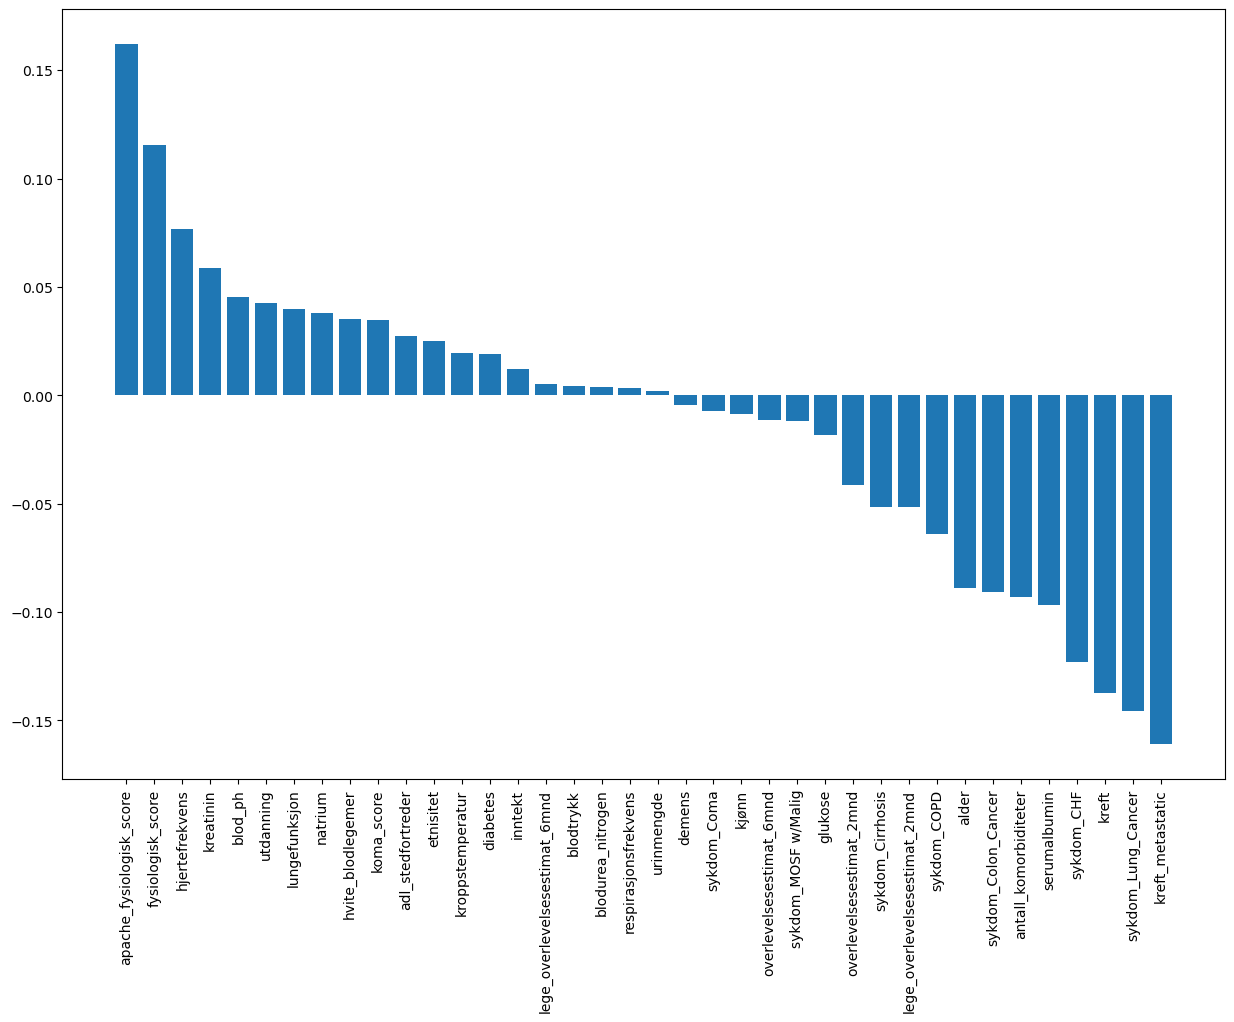

In [6494]:
correlation=train_df.corr()
corr_target=correlation['oppholdslengde'].sort_values(ascending=False)
corr_target.drop('oppholdslengde', inplace=True)

plt.figure(figsize=(15,10))
plt.bar(corr_target.index, corr_target.values)
plt.xticks(rotation=90)


plt.show()


In [6495]:
# Litt dprlig å bruke korrelasjon når vi har binære og kontinuerlige variabler, men lar den stå for nå. 
# Den fanger opp linær antagelse, og sammenheng mellom to variabler. 
# Hvis du prøver å se sammenhengen mellom en sykdom (som er binær: tilstedeværende eller ikke tilstedeværende) 
# og antall dager på sykehuset (kontinuerlig), er ikke forholdet nødvendigvis lineært. 
# For eksempel kan det være en terskel hvor tilstedeværelsen av en sykdom kraftig øker oppholdslengden, men det er ikke en jevn økning.

correlation_matrix=train_df.corr()

fig =px.imshow(correlation_matrix,
               labels=dict(x='Features', y='Features', color='Correlation'),
               x=correlation_matrix.columns,
               y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                aspect='auto')

fig.update_layout(
    yaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    ),
    autosize=False,
    height=1000,
    width=1000

)
fig.show()

## Lagrer den forberedte dataen som CSV-fil

In [6496]:
# Step 2: Concatenate X and y for each set
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Step 3: Combine all sets (train, val, test) into one DataFrame
complete_df = pd.concat([train_df, val_df, test_df])

# Optional: Reset the index to make it sequential
complete_df.reset_index(drop=True, inplace=True)

In [6497]:
df.to_csv('prepared_data.csv', index=False)
